This script investigates the influence of different audio data representations in dimensionality reduction and clustering on a dataset of goose vocalizations.

In [34]:
import glob
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns
import random
from scipy.signal import resample
import parselmouth

In [35]:
random.seed(42)

In [36]:
DATAPATH = "/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections"
clip_paths = glob.glob(DATAPATH+"/*.wav")

In [37]:
len(clip_paths)

7590

#### Inspect single call

In [38]:
i = 1300
n_fft = 512
hop_overlap = 9
top_db_silence = 35

In [39]:
vocalization, sr = librosa.load(clip_paths[i], sr=None)

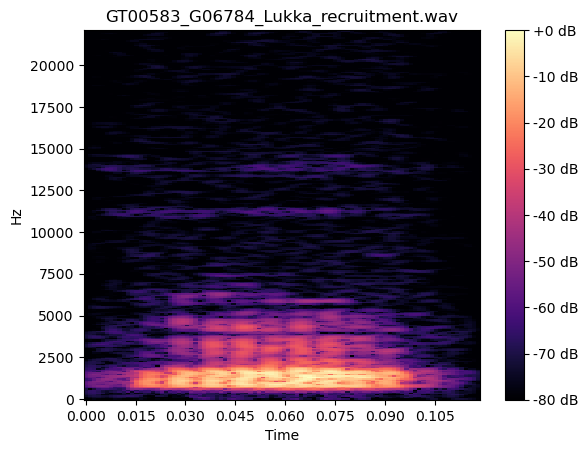

In [40]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(vocalization, n_fft=n_fft, hop_length=(n_fft//hop_overlap))), ref=np.max), sr=sr, hop_length=(n_fft//hop_overlap), x_axis='time', y_axis='linear', ax=ax)
ax.set(title=clip_paths[i].split("/")[-1])
fig.colorbar(img, ax=ax, format="%+2.f dB")

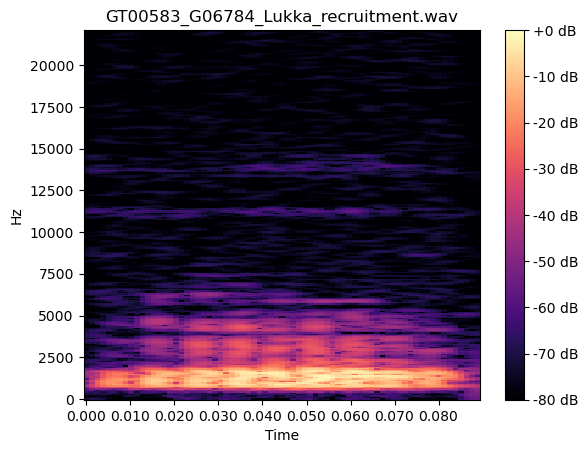

In [41]:
# trim trailing silences using db threshold, discard second entry, that holds indices
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(librosa.effects.trim(vocalization, top_db=top_db_silence, frame_length=n_fft, hop_length=(n_fft//hop_overlap))[0], n_fft=n_fft, hop_length=(n_fft//hop_overlap))), ref=np.max), sr=sr, hop_length=(n_fft//hop_overlap), x_axis='time', y_axis='linear', ax=ax)
ax.set(title=clip_paths[i].split("/")[-1])
fig.colorbar(img, ax=ax, format="%+2.f dB")

min max normalization: 
$X = \frac{X - X_{min}}{X_{max} - X_{min}}$

#### Process clips and write to dataframe
- trim
- normalize 

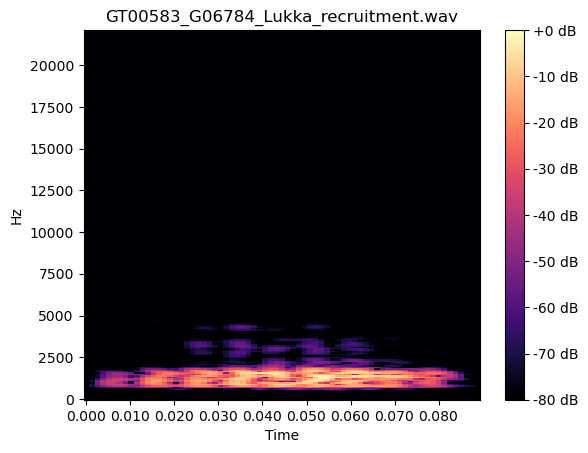

In [42]:
def min_max_scale(waveform):
    # Normalizes Spectrogram to values between 0 and 1
    return (waveform - waveform.min()) / (waveform.max() - waveform.min())
    
def peak_normalization(waveform):
    # from biosound package: https://github.com/theunissenlab/BioSoundTutorial/blob/master/BioSound1.ipynb
    return np.array((waveform / np.max(np.abs(waveform))), np.float32)

trimmed_call = librosa.effects.trim(vocalization, top_db=top_db_silence, frame_length=n_fft, hop_length=(n_fft//hop_overlap))[0]
normalized_call = peak_normalization(trimmed_call)
spec = np.abs(librosa.stft(normalized_call, n_fft=n_fft, hop_length=(n_fft//hop_overlap)))
spec_db = librosa.amplitude_to_db(spec**2, ref=np.max)
fig, ax = plt.subplots()
#img = ax.matshow(spec_db, origin="lower", cmap="viridis")
img = librosa.display.specshow(spec_db, sr=sr, n_fft=n_fft, hop_length=(n_fft//hop_overlap), x_axis='time', y_axis='linear', ax=ax)
ax.set(title=clip_paths[i].split("/")[-1])
fig.colorbar(img, ax=ax, format="%+2.f dB")

Read sound files into dataframe and preprocess inside loop:
- Trim silences
- Normalize (peak)

In [43]:
calls_df = pd.DataFrame(columns=["track_ID", "clip_ID", "goose_ID", "call_type", "waveform", "sr", "filepath"])
for clip_path in tqdm(clip_paths):
    waveform, sr = librosa.load(clip_path, sr=None)
    trimmed_waveform = librosa.effects.trim(waveform, top_db=top_db_silence, frame_length=n_fft, hop_length=(n_fft//hop_overlap))[0]
    normalized_waveform = peak_normalization(trimmed_waveform)
    filename = clip_path.split("/")[-1].split(".")[0]
    calls_df.loc[len(calls_df)] = [filename.split("_")[0], filename.split("_")[1], filename.split("_")[2], filename.split("_")[3], normalized_waveform, sr, clip_path]

  8%|▊         | 639/7590 [00:02<00:24, 289.52it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_60048/3928613055.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 30%|███       | 2303/7590 [00:07<00:17, 309.90it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_60048/3928613055.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 32%|███▏      | 2401/7590 [00:07<00:16, 315.22it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_60048/3928613055.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 32%|███▏      | 2464/7590 [00:08<00:17, 298.13it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_60048/3928613055.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(wavefo

In [44]:
len(calls_df)

7590

In [45]:
calls_df['duration'] = calls_df.apply(lambda row: len(row['waveform']) / row['sr'], axis=1)
calls_df['log_duration'] = calls_df.apply(lambda row: np.log(row['duration']), axis=1)
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,duration,log_duration
0,GT00780,G11666,Lando,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.102857,-2.274414
1,GT00772,G11510,Burglar,recruitment,"[-0.00084985833, 0.00084985833, 0.0028328612, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.100998,-2.292657
2,GT00795,G11994,EinStein,contact,"[0.004903678, 0.0052539404, 0.0038528896, 0.00...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.092698,-2.378404
3,GT00447,G04128,BruceSpringsteen,departure,"[0.00017799929, -0.00035599858, -0.001245995, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.160385,-1.830175
4,GT00775,G11567,Anthony,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00143884...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.088889,-2.420368


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_60048/1510808998.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  hist = sns.histplot(


[]

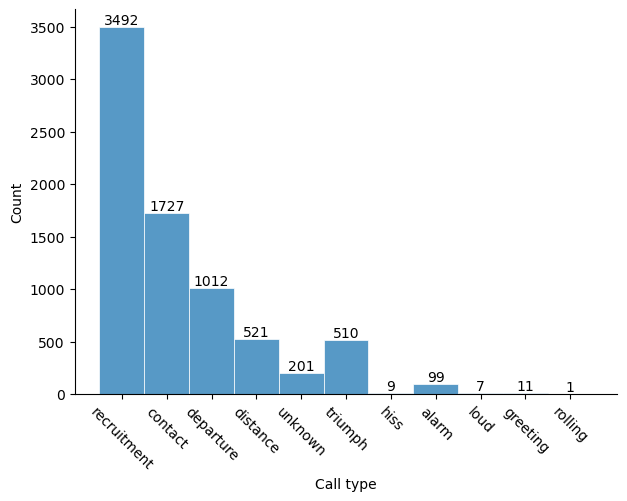

In [46]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

hist = sns.histplot(
    calls_df,
    x="call_type",
    multiple="stack",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
)

plt.xticks(rotation=-45)
ax.set_xlabel("Call type")

# Add counts
for p in hist.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.annotate(f'{int(height)}', (x, height), ha='center', va='bottom')
    
plt.plot()

Discard loud, greeting and rolling calls and only keep random subset of recruitment, departure and contact calls to balance the representations of the different classes

In [47]:
# discard loud, greeting and rolling calls
calls_df = calls_df[~calls_df['call_type'].isin(['loud', 'greeting', 'rolling'])]

In [48]:
# only keep random subset of recruitment, departure and contact calls
subset_size = 700

subsample_sizes = {
    'recruitment': subset_size,
    'contact': subset_size,
    'departure': subset_size,
}

# Randomly subsample per call type
def subsample_group(group):
    call_type = group.name  # Group name corresponds to call type
    if call_type in subsample_sizes:
        return group.sample(n=subsample_sizes[call_type], random_state=42)
    return group  # Return untouched if no subsampling is needed

# Group by type and apply subsampling
calls_df = calls_df.groupby('call_type', group_keys=False).apply(subsample_group)

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_60048/759216624.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calls_df = calls_df.groupby('call_type', group_keys=False).apply(subsample_group)


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_60048/1510808998.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  hist = sns.histplot(


[]

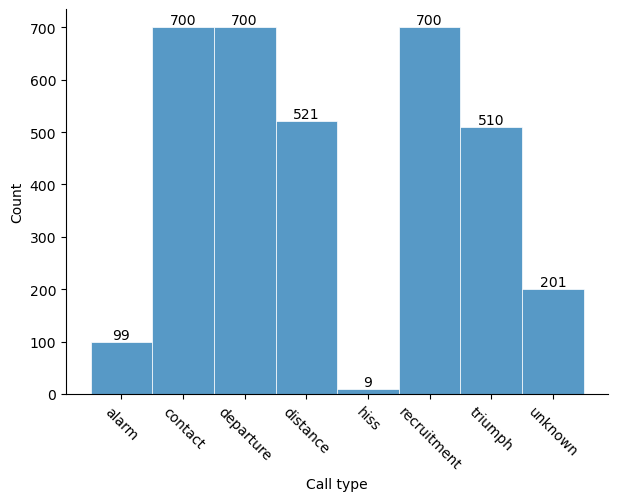

In [49]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

hist = sns.histplot(
    calls_df,
    x="call_type",
    multiple="stack",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
)

plt.xticks(rotation=-45)
ax.set_xlabel("Call type")

# Add counts
for p in hist.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.annotate(f'{int(height)}', (x, height), ha='center', va='bottom')
    
plt.plot()

Plot the durations of the calls

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_60048/1401958112.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'alarm'),
  Text(1, 0, 'contact'),
  Text(2, 0, 'departure'),
  Text(3, 0, 'distance'),
  Text(4, 0, 'hiss'),
  Text(5, 0, 'recruitment'),
  Text(6, 0, 'triumph'),
  Text(7, 0, 'unknown')])

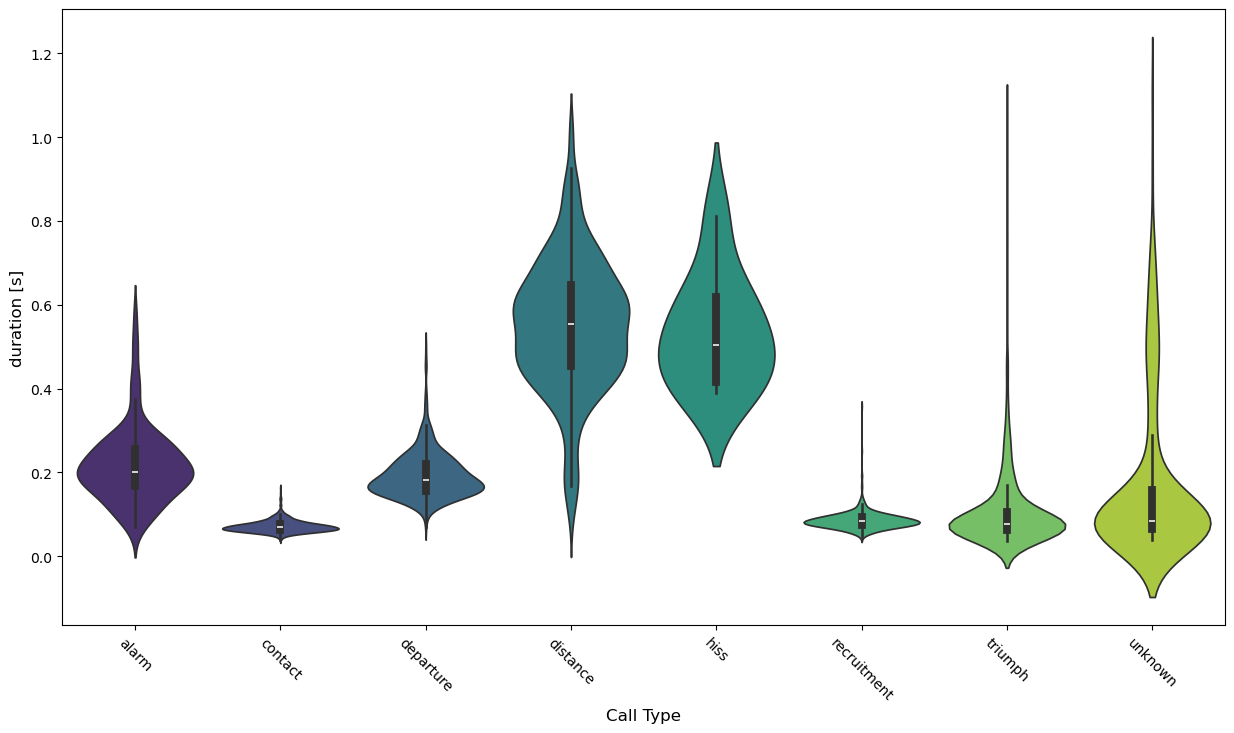

In [50]:
plt.figure(figsize=(15, 8))
sns.violinplot(
    data=calls_df,
    x="call_type",
    y="duration",
    palette="viridis",
    density_norm="width" 
)

plt.xlabel("Call Type", fontsize=12)
plt.ylabel("duration [s]", fontsize=12)
plt.xticks(rotation=-45)

Because the call durations vary substantially, we will log scale the times before padding to the longest call:

In [51]:
longest_call = calls_df.loc[calls_df["duration"].idxmax()]
max_log_duration = longest_call["log_duration"]
max_duration_seconds = longest_call["duration"]
max_samples = len(longest_call["waveform"])
shortest_call = calls_df.loc[calls_df["duration"].idxmin()]
min_log_duration = shortest_call["log_duration"]
min_duration_seconds = shortest_call["duration"]

# Compute log scaled target length for the waveform
calls_df["normalized_log_length"] = calls_df.apply(lambda row: (row["log_duration"]-min_log_duration)/(max_log_duration-min_log_duration), axis=1)
calls_df["target_duration"] = calls_df.apply(lambda row: row["normalized_log_length"]*(max_duration_seconds-min_duration_seconds)+min_duration_seconds, axis=1)

print(calls_df.loc[calls_df["duration"].idxmin()]["target_duration"], min_duration_seconds)
print(calls_df.loc[calls_df["duration"].idxmax()]["target_duration"], max_duration_seconds)

# Resample and pad waveforms
def rescale_and_pad(waveform, target_duration, sr, target_samples):
    if waveform is None or len(waveform) == 0:
        print("Empty or None waveform")
        return None
    
    if np.isnan(waveform).any():
        print("Waveform contains NaN values")
        return None

    target_length = int(target_duration * sr)

    try:
        # Resample waveform to match the target length
        rescaled_waveform = resample(waveform, target_length)
        if np.isnan(rescaled_waveform).any():
            print("NaN in resampled waveform")
            return None
    except Exception as e:
        print(f"Error during resampling: {e}")
        return None

    total_padding = target_samples - target_length
    if total_padding < 0:
        print("Target length exceeds target samples")
        return None

    left_padding = total_padding // 2
    right_padding = total_padding - left_padding
    padded_waveform = np.pad(rescaled_waveform, (left_padding, right_padding))
    
    if np.isnan(padded_waveform).any():
        print("NaN in padded waveform")
        return None
    return padded_waveform

# Apply transformation to each waveform
calls_df["log_padded_waveform"] = calls_df.apply(
    lambda row: rescale_and_pad(
        row["waveform"],
        row["target_duration"],
        row["sr"],
        max_samples
    ),
    axis=1
)

0.036825396825396824 0.036825396825396824
1.1034920634920635 1.1034920634920635
Waveform contains NaN values
Waveform contains NaN values
Waveform contains NaN values
Waveform contains NaN values
Waveform contains NaN values
Waveform contains NaN values
Waveform contains NaN values
Waveform contains NaN values
Waveform contains NaN values
Waveform contains NaN values


In [52]:
calls_df[calls_df.isna().any(axis=1)]

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,duration,log_duration,normalized_log_length,target_duration,log_padded_waveform
659,GT00989,G14229,unknown,alarm,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.286803,-1.248961,0.603700,0.680772,None
2428,GT00984,G12682,Bregenz,triumph,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.083583,-2.481918,0.241070,0.293967,None
6621,GT00984,G12602,Kruemmel,triumph,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.131315,-2.030155,0.373940,0.435694,None
2334,GT00984,G12616,Kruemmel,unknown,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.069637,-2.664457,0.187383,0.236701,None
2472,GT00984,G12619,Kruemmel,unknown,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.074286,-2.599837,0.206389,0.256973,None
3341,GT00984,G12633,Kruemmel,unknown,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.069660,-2.664131,0.187479,0.236803,None
5117,GT00984,G12622,Kruemmel,unknown,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.046417,-3.070084,0.068082,0.109447,None
5378,GT00984,G12615,Kruemmel,unknown,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.083583,-2.481918,0.241070,0.293967,None
5761,GT00984,G12631,Kruemmel,unknown,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.064989,-2.733542,0.167064,0.215027,None
6642,GT00984,G12763,Bregenz,unknown,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.055714,-2.887519,0.121777,0.166721,None


In [53]:
calls_df = calls_df.dropna()

Plot log scaled lengths and rescaled length as sanity check before padding

[]

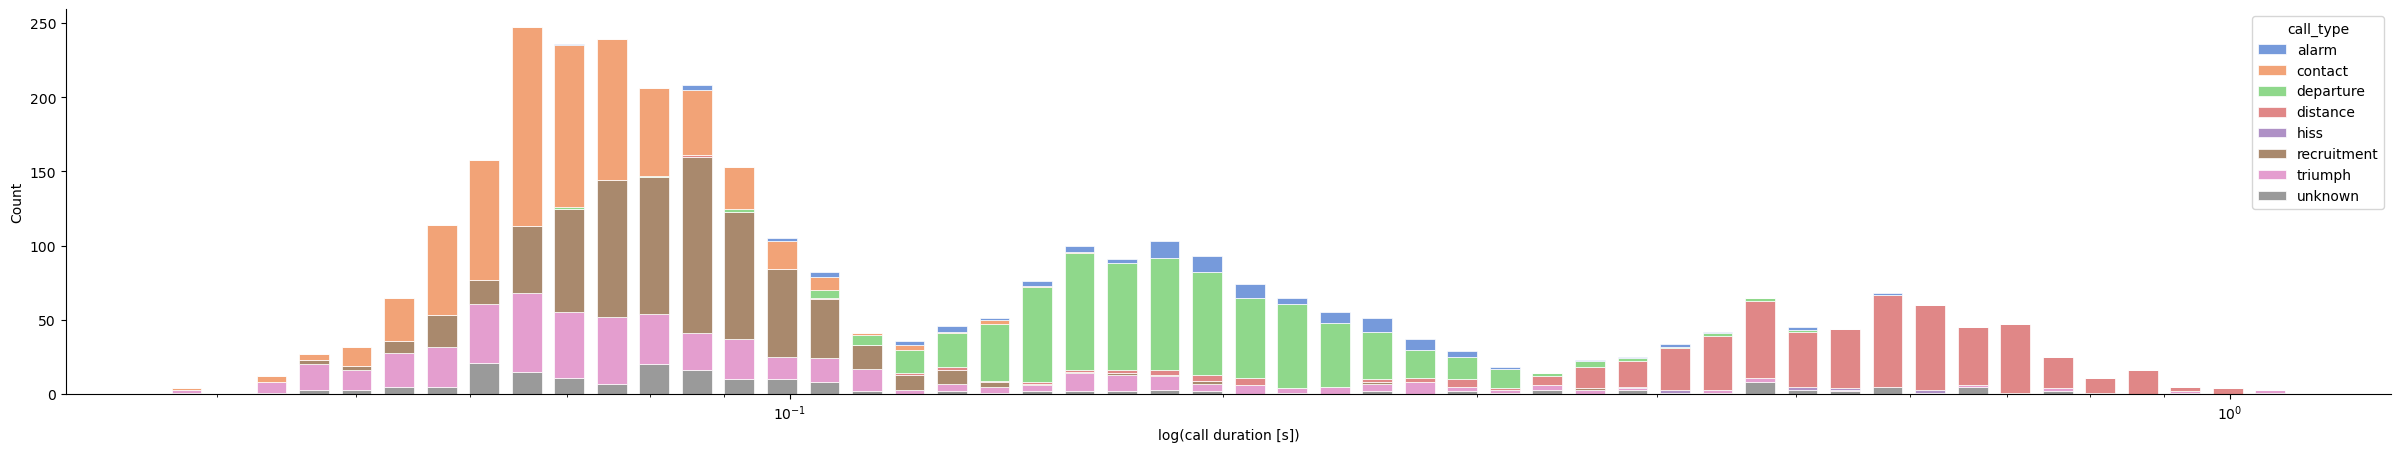

In [54]:
f, ax = plt.subplots(figsize=(30, 5))
sns.despine(f)

sns.histplot(
    calls_df,
    x="duration",
    multiple="stack",
    hue="call_type",
    palette="muted",
    edgecolor="1",
    linewidth=.5,
    shrink=.7,
    bins=50,
    log_scale=True
)
ax.set_xlabel("log(call duration [s])")
plt.plot()

[]

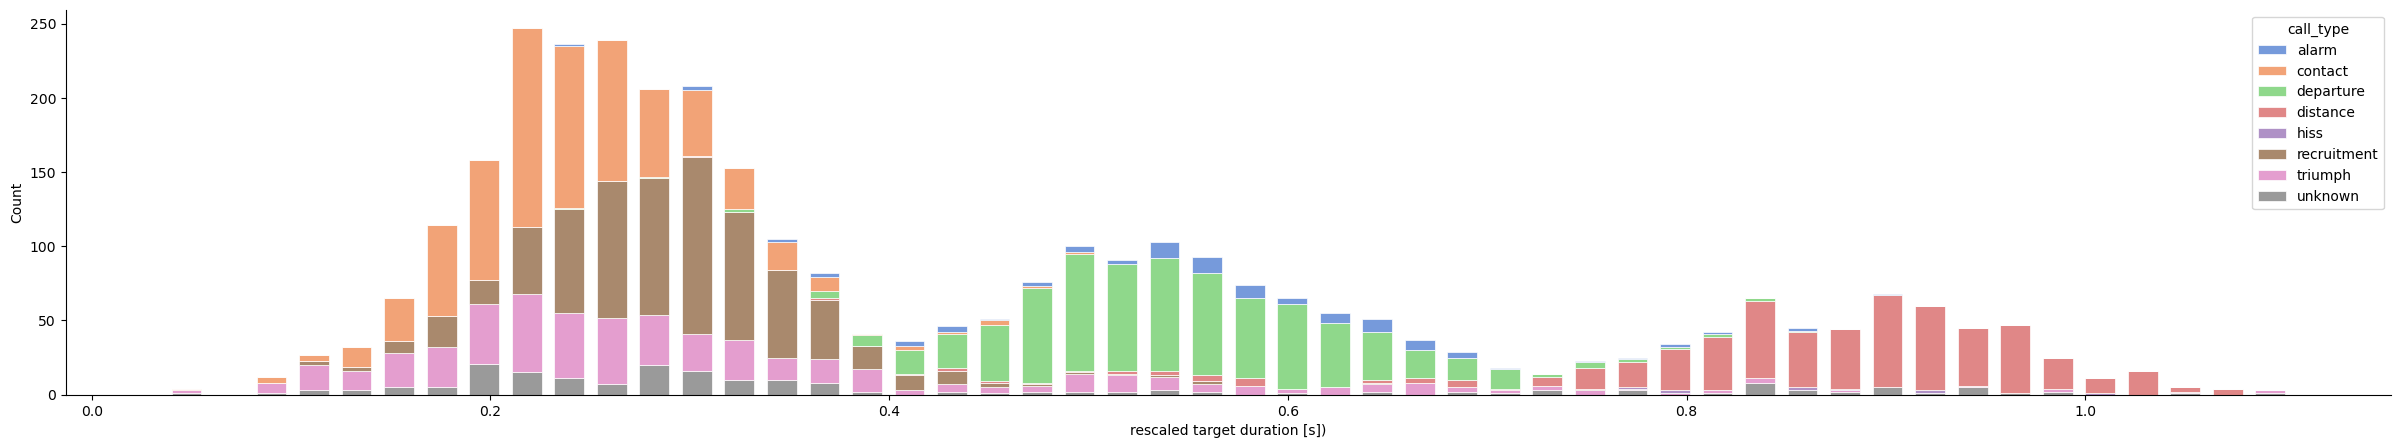

In [55]:
f, ax = plt.subplots(figsize=(30, 5))
sns.despine(f)

sns.histplot(
    calls_df,
    x="target_duration",
    multiple="stack",
    hue="call_type",
    palette="muted",
    edgecolor="1",
    linewidth=.5,
    shrink=.7,
    bins=50,
)
ax.set_xlabel("rescaled target duration [s])")
plt.plot()

In [56]:
def pad_to_length(waveform, target_length):
    padding_total = target_length - len(waveform) 
    padding_before = padding_total // 2
    padding_after = padding_total - padding_before
    return np.pad(waveform, (padding_before, padding_after), mode='constant')


# Apply transformation to each waveform
calls_df["padded_waveform"] = calls_df.apply(
    lambda row: pad_to_length(
        row["waveform"],
        len(calls_df.loc[calls_df["duration"].idxmax()]["waveform"])
    ),
    axis=1
)

In [57]:
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,duration,log_duration,normalized_log_length,target_duration,log_padded_waveform,padded_waveform
223,GT00052,G00282,Dagobert,alarm,"[-0.0008866558, -0.0008866558, -0.0005172159, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.199365,-1.612618,0.496743,0.566685,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
282,GT00058,G00331,Besenstiel,alarm,"[-0.0035644849, -0.0035644849, -0.0038885288, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.165079,-1.801329,0.441241,0.507482,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
328,GT00989,G14230,unknown,alarm,"[-0.036363635, 0.07878788, 0.018181818, -0.078...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.088889,-2.420368,0.259173,0.313276,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
362,GT00055,G00310,Lausbursch,alarm,"[-0.009191881, -0.0099578705, -0.010340866, -0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.300952,-1.200803,0.617863,0.695880,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
720,GT00989,G14235,unknown,alarm,"[-0.006441224, -0.001610306, -0.006441224, -0....",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.167619,-1.786061,0.445731,0.512272,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


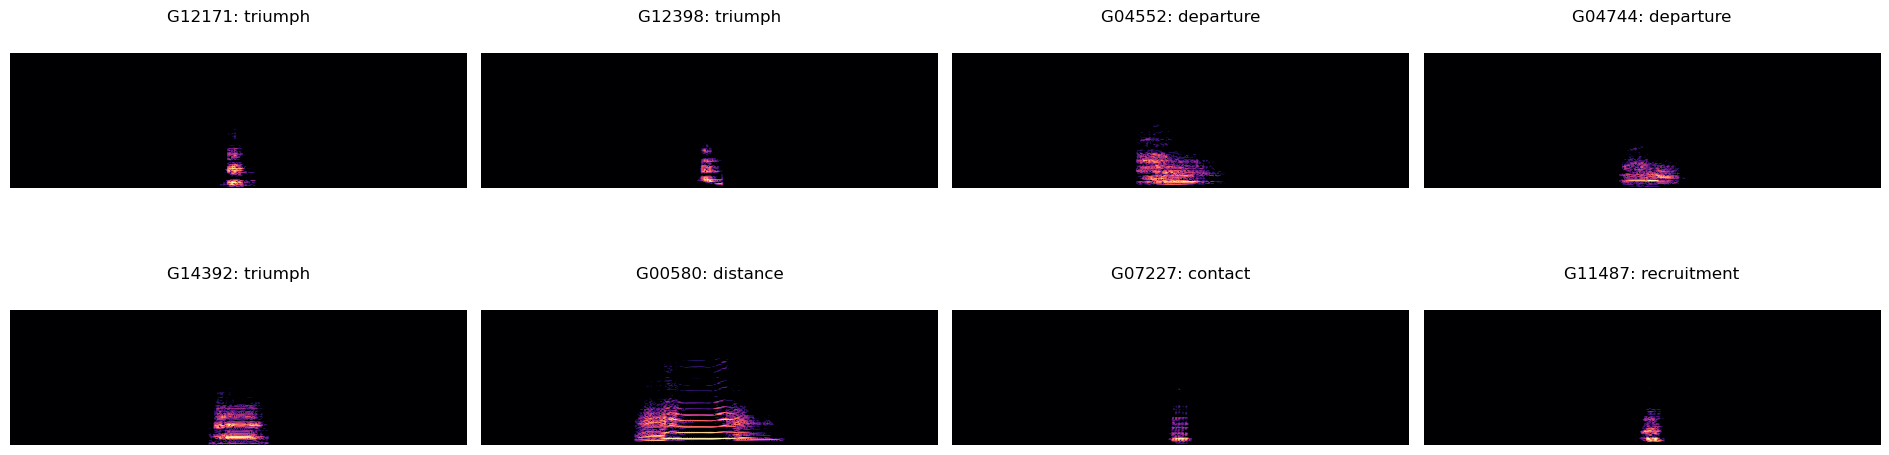

In [58]:
# plot random sample of 8 calls
sample_calls = calls_df.sample(n=8, random_state=43)

# plot first 8 calls
#sample_calls = calls_df.iloc[:8]

fig, axes = plt.subplots(2, 4, figsize=(19, 6))

for i, (_, vocalization) in enumerate(sample_calls.iterrows()):
    row = i // 4
    col = i % 4
    transformed = librosa.amplitude_to_db(
        np.abs(librosa.stft(vocalization["padded_waveform"], n_fft=n_fft, hop_length=(n_fft//hop_overlap)))**2, 
        ref=np.max)
    axes[row, col].matshow(transformed, origin="lower", cmap="magma")
    axes[row, col].set_title(f'{vocalization["clip_ID"]}: {vocalization["call_type"]}', )
    axes[row, col].axis("off") 
    
for i in range(len(sample_calls), 8):
  row = i // 4
  col = i % 4
  axes[row, col].axis("off")

plt.tight_layout()
plt.show()

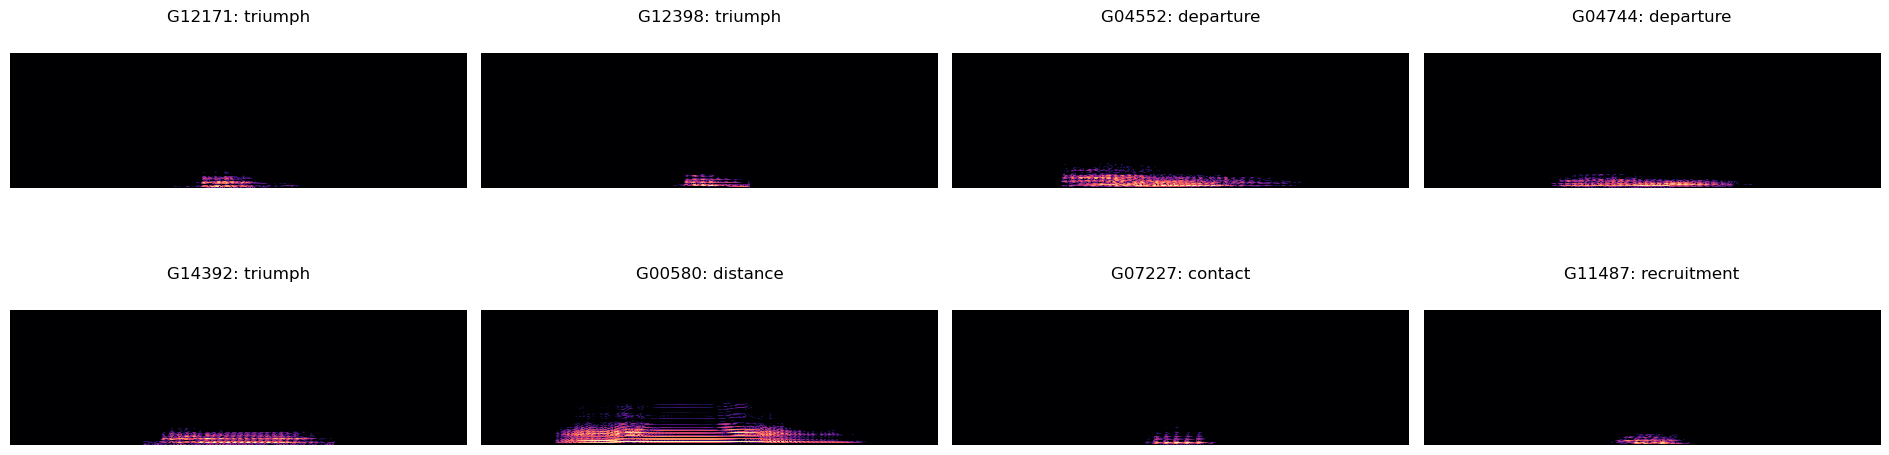

In [59]:
# plot random sample of 8 calls
sample_calls = calls_df.sample(n=8, random_state=43)

# plot first 8 calls
#sample_calls = calls_df.iloc[:8]

fig, axes = plt.subplots(2, 4, figsize=(19, 6))

for i, (_, vocalization) in enumerate(sample_calls.iterrows()):
    row = i // 4
    col = i % 4
    transformed = librosa.amplitude_to_db(
        np.abs(librosa.stft(vocalization["log_padded_waveform"], n_fft=n_fft, hop_length=(n_fft//hop_overlap)))**2, 
        ref=np.max)
    axes[row, col].matshow(transformed, origin="lower", cmap="magma")
    axes[row, col].set_title(f'{vocalization["clip_ID"]}: {vocalization["call_type"]}', )
    axes[row, col].axis("off") 
    
for i in range(len(sample_calls), 8):
  row = i // 4
  col = i % 4
  axes[row, col].axis("off")

plt.tight_layout()
plt.show()

#### Extract audio features using **Praat/Parselmouth**: 


**Temporal features (retrieved from temporal envelope in amlitude pressure):**
- Mean T: temporal centroid
- Std T: temporal duration
- Skew T: temporal skewness (asymmery)
- Kurt T: temporal kurtosis (peakedness)
- Ent T: temporal entropy (overall variability)

**Spectral features (from spectral envelope in power/pressure square):**
- Mean S: spectral centroid
- Std S: spectral duration
- Skew S: spectral skewness (asymmery)
- Kurt S: spectral kurtosis (peakedness)
- Ent S: spectral entropy (overall variability)
- Q1, Q2, G3: q-th quartile of power spectrum

**From time-varying fundamental frequency:**
- Mean F0: mean fundamental frequency
- Sal: mean pitch saliency (ratio)
- Max F0: mean fundamental
- Min F0: minimum fundamental
- CV F0: coefficient of variation (measure of frequency modulation)

In [157]:
f0min = 350
f0max = 2000

In [172]:
def plot_spectrogram(snd, pitch=None, dynamic_range=70):
    spectrogram = snd.to_spectrogram()

    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

    if pitch:
        plt.twinx()
        plt.xlim([snd.xmin, snd.xmax])
        _plot_pitch(pitch, ylim=[spectrogram.ymin, spectrogram.ymax])

def _plot_pitch(pitch, ylim=[]):
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    if ylim==[]:
        plt.ylim(0, pitch.ceiling)
    else: 
        plt.ylim(ylim)
    plt.ylabel("fundamental frequency [Hz]")

In [ ]:
# fundamental
"""
- Mean F0: mean fundamental frequency
- Sal: mean pitch saliency (ratio)
- Max F0: mean fundamental
- Min F0: minimum fundamental
- CV F0: coefficient of variation (measure of frequency modulation)
"""
def calculate_f0(snd, f0min, f0max):
    # https://parselmouth.readthedocs.io/en/stable/api_reference.html#parselmouth.Sound.to_pitch
    pitch = parselmouth.praat.call(snd, "To Pitch", 0, f0min, f0max)
    f0mean = parselmouth.praat.call(pitch, "Get mean", 0, 0, "Hertz")
    f0stdDev = parselmouth.praat.call(pitch, "Get standard deviation", 0, 0, "Hertz")
    f0min = parselmouth.praat.call(pitch, "Get minimum", 0, 0, "Hertz", "parabolic")
    f0max = parselmouth.praat.call(pitch, "Get maximum", 0, 0, "Hertz", "parabolic")
    f0range = f0max - f0min
    return f0mean , f0range, f0stdDev, pitch

# spectral
def calculate_hnr(snd):
    harmonicity = snd.to_harmonicity()
    return harmonicity.values[harmonicity.values != -200].mean()

"""
- Mean S: spectral centroid
- Std S: spectral duration
- Skew S: spectral skewness (asymmery)
- Kurt S: spectral kurtosis (peakedness)
- Ent S: spectral entropy (overall variability)
- Q1, Q2, G3: q-th quartile of power spectrum
"""

# temporal
"""
- Mean T: temporal centroid
- Std T: temporal duration
- Skew T: temporal skewness (asymmery)
- Kurt T: temporal kurtosis (peakedness)
- Ent T: temporal entropy (overall variability)
"""

'\n- Mean T: temporal centroid\n- Std T: temporal duration\n- Skew T: temporal skewness (asymmery)\n- Kurt T: temporal kurtosis (peakedness)\n- Ent T: temporal entropy (overall variability)\n'

In [190]:
def calc_features(row, n_fft):
    snd = parselmouth.Sound(row["filepath"])
    spectrogram = np.abs(librosa.stft(row["waveform"], n_fft=n_fft)) 
    f0mean, f0range, f0std_dev, pitch = calculate_f0(snd, f0min, f0max)
    hnr = calculate_hnr(snd)
    spectrum = snd.to_spectrum()
    centroid = spectrum.get_center_of_gravity()
    skewness = spectrum.get_skewness()
    kurtosis = spectrum.get_kurtosis()
    plot_spectrogram(snd, pitch)
    print(f"\
        spectral centroid: {centroid}, \n\
        skewness: {skewness}, \n\
        spectral kurtosis: {kurtosis},\n")
    return f0mean, f0range, f0std_dev, pitch, centroid, hnr, skewness, kurtosis

        spectral centroid: 1414.5246592742558, 
        skewness: 7.570105903566773, 
        spectral kurtosis: 119.18754087999558,



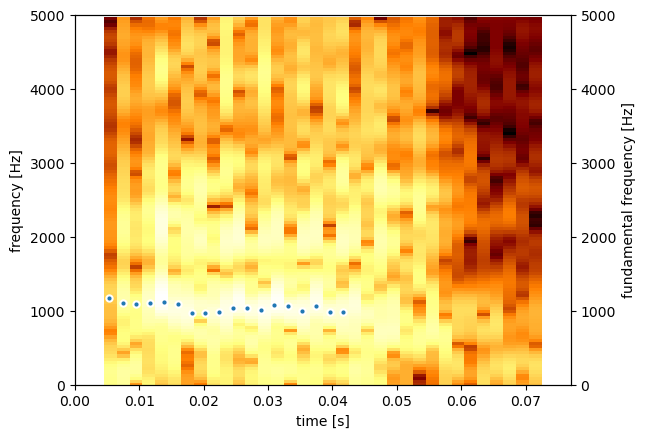

In [191]:
f0mean, f0range, f0std_dev, pitch, centroid, hnr, skewness, kurtosis = calc_features(calls_df.iloc[100], n_fft)

##### Analyze spectrograms

In [ ]:
def scale_minmax(X, min=0.0, max=1.0):
    #from https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [ ]:
calls_df[calls_df.isna().any(axis=1)]

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,duration,log_duration,normalized_log_length,target_duration,log_padded_waveform,padded_waveform


In [ ]:
def transform(row):
    transformed = librosa.amplitude_to_db(
        np.abs(librosa.stft(row["log_padded_waveform"], n_fft=n_fft, hop_length=(n_fft//hop_overlap)))**2, 
        ref=np.max)
    scaled = scale_minmax(transformed, 0, 255).astype(np.uint8)/255. # transform to pixel values and normalize 
    flipped = np.flip(scaled, axis=0) # flip low frequencies to the bottom of the image
    reduced = flipped[::4, ::4] # reduce to a quarter of the size
    spectrogram = reduced[int(len(reduced)*0.7):, :] # cut out higher frequencies where no power is left
    spectrogram = spectrogram[:, spectrogram.shape[1]//9:-spectrogram.shape[1]//9] # cut outer bins on time axis
    return row["call_type"], row["track_ID"], row["goose_ID"], spectrogram

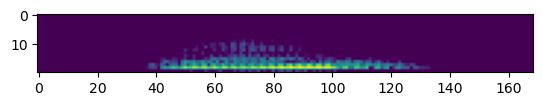

(20, 169)


In [ ]:
# longest call
#vocalization = calls_df.loc[calls_df["duration"].idxmax()]
# random call
vocalization = calls_df.iloc()[np.random.randint(0, len(calls_df))]

call_type, track_id, goose_id, spectrogram = transform(vocalization)

plt.imshow(spectrogram)
plt.show()
print(spectrogram.shape)

In [ ]:
labels_and_spectrograms = []
for idx, row in calls_df.iterrows():
    call_type, track_id, goose_id, spec = transform(row)
    labels_and_spectrograms.append([call_type, track_id, goose_id, *spec.flatten()])

In [ ]:
column_names = ["call_type", "track_ID", "goose_ID"]
for i in range(len(spec.flatten())):
    column_names.append(i)

In [ ]:
labels_and_spectrograms_df = pd.DataFrame(labels_and_spectrograms, columns=column_names, index=None) 

In [ ]:
labels_and_spectrograms_df.head()

,call_type,track_ID,goose_ID,0,1,2,3,4,5,6,...,3370,3371,3372,3373,3374,3375,3376,3377,3378,3379
0,alarm,GT00052,Dagobert,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,alarm,GT00058,Besenstiel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,alarm,GT00989,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,alarm,GT00055,Lausbursch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,alarm,GT00989,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### UMAP

In [ ]:
import umap
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch

from mpl_toolkits.mplot3d import Axes3D

ModuleNotFoundError: No module named 'umap'

In [ ]:
labels_and_spectrograms_scaled = StandardScaler().fit_transform(labels_and_spectrograms_df.drop(columns=["call_type", "track_ID", "goose_ID"]))
embeddings = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1).fit_transform(labels_and_spectrograms_scaled)

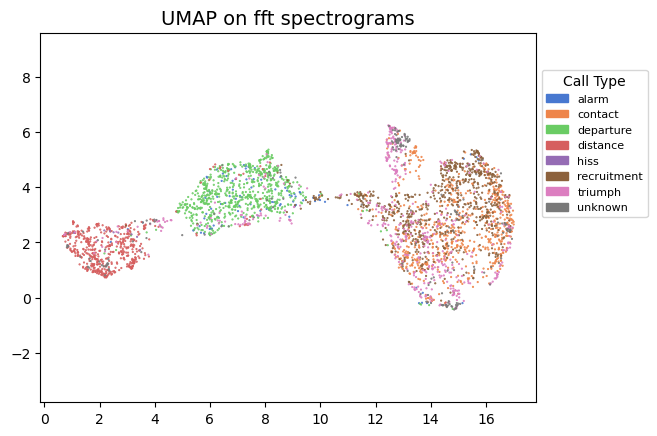

In [ ]:
unique_goose_ids = labels_and_spectrograms_df["call_type"].unique()
color_palette = sns.color_palette("muted", len(unique_goose_ids))
goose_id_to_color = {call_type: color for call_type, color in zip(unique_goose_ids, color_palette)}

# Assign colors to points
colors = [goose_id_to_color[call_type] for call_type in labels_and_spectrograms_df["call_type"]]

# Scatter plot
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on fft spectrograms', fontsize=14)

# Legend
legend_patches = [Patch(color=color, label=call_type) for call_type, color in goose_id_to_color.items()]
plt.legend(
    handles=legend_patches,
    title="Call Type",
    fontsize=8,
    title_fontsize=10,
    loc="center left",
    bbox_to_anchor=(1.0, 0.7)
)

plt.show()

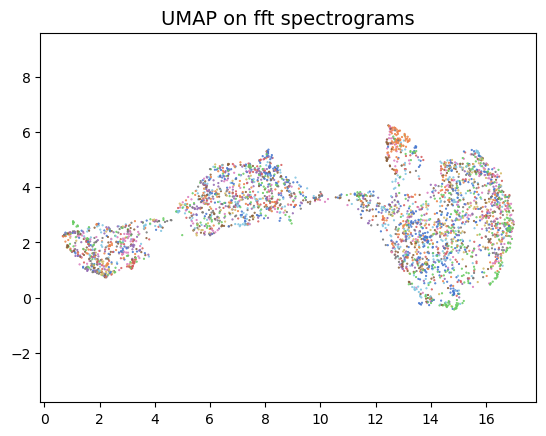

In [ ]:
unique_track_ids = labels_and_spectrograms_df["track_ID"].unique()
color_palette = sns.color_palette("muted", len(unique_track_ids))
goose_id_to_color = {track_id: color for track_id, color in zip(unique_track_ids, color_palette)}

# Assign colors to points
colors = [goose_id_to_color[track_id] for track_id in labels_and_spectrograms_df["track_ID"]]

# Scatter plot
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on fft spectrograms', fontsize=14)

# Legend
# legend_patches = [Patch(color=color, label=track_id) for track_id, color in track_id_to_color.items()]
# plt.legend(
#     handles=legend_patches,
#     title="Track_ID",
#     fontsize=8,
#     title_fontsize=10,
#     loc="center left",
#     bbox_to_anchor=(1.0, 0.7)
# )

plt.show()

GT00220 is clustered very clearly...

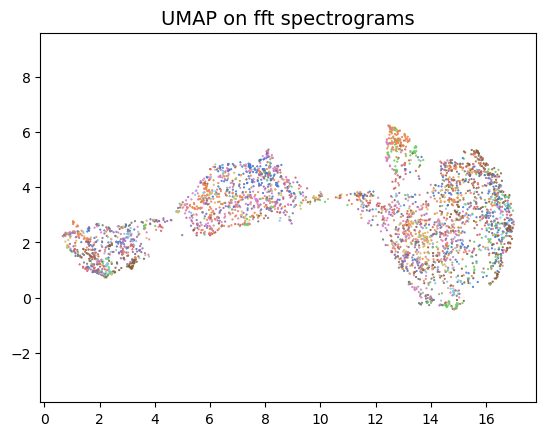

In [ ]:
unique_goose_ids = labels_and_spectrograms_df["goose_ID"].unique()
color_palette = sns.color_palette("muted", len(unique_goose_ids))
goose_id_to_color = {goose_id: color for goose_id, color in zip(unique_goose_ids, color_palette)}

# Assign colors to points
colors = [goose_id_to_color[goose_id] for goose_id in labels_and_spectrograms_df["goose_ID"]]

# Scatter plot
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on fft spectrograms', fontsize=14)

# Legend
# legend_patches = [Patch(color=color, label=goose_id) for goose_id, color in goose_id_to_color.items()]
# plt.legend(
#     handles=legend_patches,
#     title="Goose ID",
#     fontsize=8,
#     title_fontsize=10,
#     loc="center left",
#     bbox_to_anchor=(1.0, 0.7)
# )

plt.show()

In [ ]:
embeddings3d = umap.UMAP(n_neighbors=15, n_components=3, min_dist=0.1).fit_transform(labels_and_spectrograms_scaled)

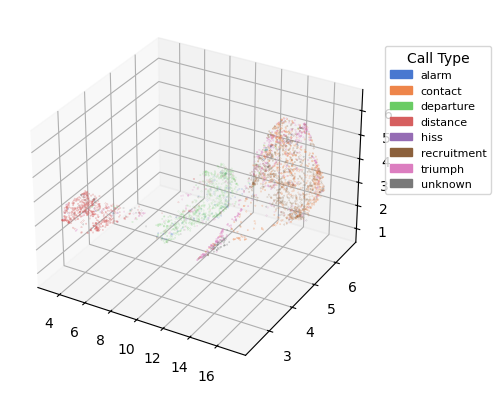

In [ ]:
unique_goose_ids = labels_and_spectrograms_df["call_type"].unique()
color_palette = sns.color_palette("muted", len(unique_goose_ids))
goose_id_to_color = {call_type: color for call_type, color in zip(unique_goose_ids, color_palette)}

# Assign colors to points
colors = [goose_id_to_color[call_type] for call_type in labels_and_spectrograms_df["call_type"]]

# for 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
ax.scatter( 
    embeddings3d[:, 0],  
    embeddings3d[:, 1],
    embeddings3d[:, 2],  
    c=colors,
    s=0.03)

legend_patches = [Patch(color=color, label=call_type) for call_type, color in goose_id_to_color.items()]
plt.legend(
    handles=legend_patches,
    title="Call Type",
    fontsize=8,
    title_fontsize=10,
    loc="center left",
    bbox_to_anchor=(1.0, 0.7)
)